# Back-Testing for Algorithmic Trading Strategies

<b>How to choose a strategy? It would be a good start to test alternative strategies retrospectively, knowing which of these strategies worked best in the past and produced more accurate signals. This is called Back-Test.<b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yahoofinancials as yf
from yahoo_fin.stock_info import *
import requests_html
import requests
import ftplib
import ta as ta


<b>Let's get the historical time series data of the stock by specifying the start and end dates<b>

In [2]:
history = yf.YahooFinancials('TSLA').get_historical_price_data('2021-01-01', '2021-12-31', 'daily')
df = pd.DataFrame(history['TSLA']['prices'])
df.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1609770600,248.163330,239.063339,239.820007,243.256668,145914600,243.256668,2021-01-04
1,1609857000,246.946671,239.733337,241.220001,245.036667,96735600,245.036667,2021-01-05
2,1609943400,258.000000,249.699997,252.830002,251.993332,134100000,251.993332,2021-01-06
3,1610029800,272.329987,258.399994,259.209991,272.013336,154496700,272.013336,2021-01-07
4,1610116200,294.829987,279.463318,285.333344,293.339996,225166500,293.339996,2021-01-08


In [3]:
df.drop('date', axis=1, inplace=True)

In [4]:
df.index = pd.to_datetime(df['formatted_date'])
df.drop('formatted_date', axis=1, inplace=True)

<b>Let's change the name of the adjclose variable to 'Price'.<b>

In [5]:
df.rename(columns={'adjclose': 'price'}, inplace=True)

<b>Let's change the price change to 'return' (daily return) and assign the percentage change in the price to 'return_pct'.

In [6]:
df["return"] = df["price"].diff()
df["return_pct"] = df["price"].pct_change()

<b>Time Series Graph of Price and Return

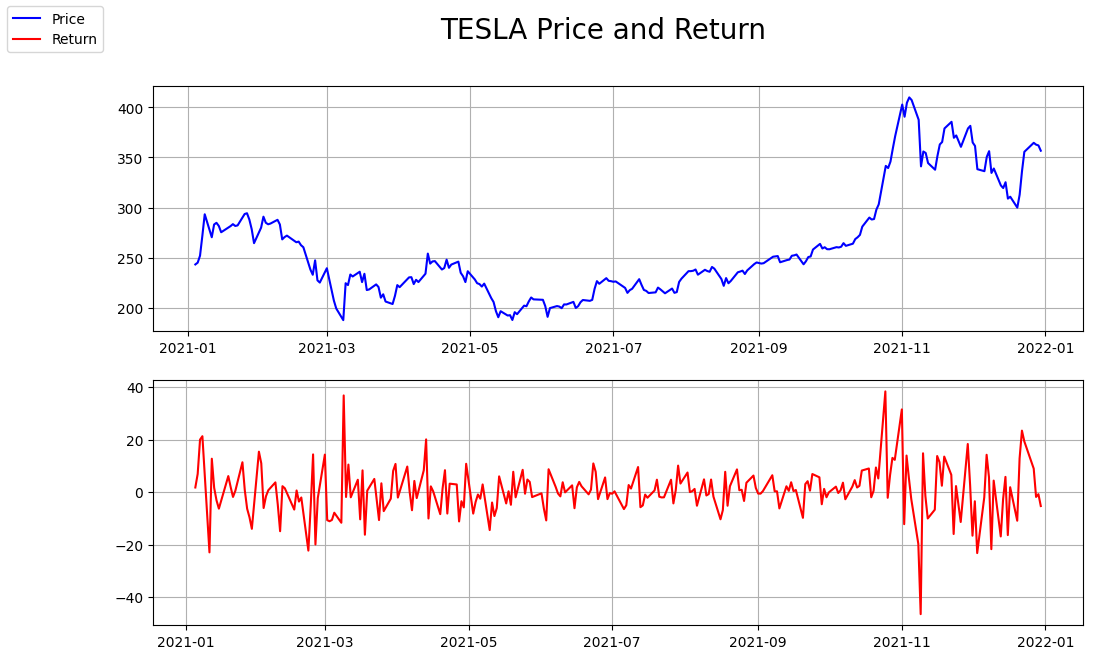

In [7]:
f, axarr = plt.subplots(2,sharex=False,figsize=(12,7))
f.suptitle('TESLA Price and Return', fontsize=20)
axarr[0].plot(df['price'], color='blue')
axarr[0].grid(True)
axarr[1].plot(df['return'], color='red')
axarr[1].grid(True)
f.legend(['Price', 'Return'], loc='upper left')
plt.show()

# Three Alternative Strategies

- <b>1) Price > EMA10 : If the price goes above the 10-day exponential moving average, it is considered a buy signal.<b>

- <b>2) EMA10 > EMA30 : When the 10-day exponential moving average rises above the 30-day exponential moving average, it can be considered as a buy signal.<b>

- <b>3) MACD > MACDS : The MACD indicator is the difference between the exponential values of the 26 and 12-day moving average. The 9-day exponential moving average of the MACD is called the MACD Signal (MACDS). If the MACD goes above the MACDS, it is considered a buy signal.<b>

<b>1) Price > EMA10  (s1)

In [8]:
df["EMA10"] = ta.trend.ema_indicator(df["price"],10,fillna=True)

<b>Let's create Buy-Sell Signals

In [9]:
df["buy_s1"] = np.where(df["price"] > df["EMA10"], 1, 0)
df["sell_s1"] = np.where(df["price"] < df["EMA10"], 1, 0)
df["buy_s1_ind"] = np.where((df["buy_s1"] > df["buy_s1"].shift(1)),1, 0)
df["sell_s1_ind"] = np.where((df["sell_s1"] > df["sell_s1"].shift(1)),1, 0)

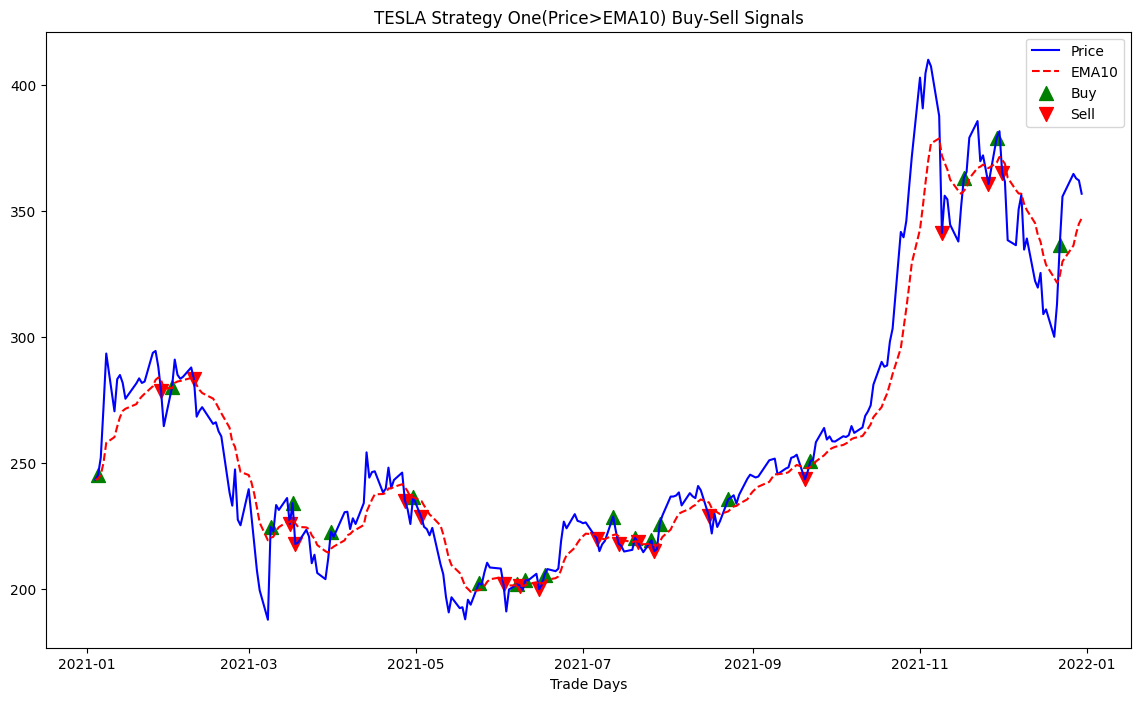

In [10]:
df["date"] = df.index

fig1 = plt.figure(figsize=(14,8))
plt.plot(df["price"],label="Price",color='blue')
plt.plot(df["EMA10"],label="EMA10",color='red',linestyle='--')
plt.scatter(df.loc[df["buy_s1_ind"] == 1].index, 
            df["price"][df["buy_s1_ind"] == 1], color='green', marker='^', s=100, label="Buy")

plt.scatter(df.loc[df["sell_s1_ind"] == 1].index,
            df["price"][df["sell_s1_ind"] == 1], color='red', marker='v', s=100, label="Sell")

plt.xlabel('Trade Days')
plt.legend(loc='best')
plt.title('TESLA Strategy One(Price>EMA10) Buy-Sell Signals')
plt.show()

<b>According to the Strategy One, the profit of the trader who trades with $1000 in the relevant period:

Assuming we allocate 5% of the return as transaction costs, then we will consider 95% of the percentage return.<b>

In [11]:
df["values_s1"] = 1000*(1+(np.where(df["buy_s1"]==1,
                                0.95*df["return_pct"],0)).cumsum())

# Back-Test Report

In [12]:
print("************* Descriptive Statistics *************")
print("Period",len(df),"days")
print("Highest Daily Loss ",100*round(df["return_pct"].min(),2),"%")
print("Highest Daily Return ",100*round(df["return_pct"].max(),2),"%")
print("Standard Deviation of Return ",100*round(df["return_pct"].std(),2),"%")
print("Total Potential Return ",100*(round(sum(np.where((df["return_pct"]>0),df["return_pct"],0)),2)),"%")
print("Total Potential Loss ",100*(round(sum(np.where((df["return_pct"]<0),df["return_pct"],0)),2)),"%")
print("Net Return ",100*df["return_pct"].sum().round(2),"%")

print("************* MODEL PERFORMANCE *************")

print("Return Captured by the Model ",100*sum(np.where((df["buy_s1"]==1),df["return_pct"],0)).round(2),"%")
print("Loss Maintained by the Model ",100*sum(np.where((df["sell_s1"]==1),df["return_pct"],0)).round(2),"%")
print("**************************************************")


************* Descriptive Statistics *************
Period 251 days
Highest Daily Loss  -12.0 %
Highest Daily Return  20.0 %
Standard Deviation of Return  3.0 %
Total Potential Return  336.0 %
Total Potential Loss  -283.0 %
Net Return  53.0 %
************* MODEL PERFORMANCE *************
Return Captured by the Model  200.0 %
Loss Maintained by the Model  -147.0 %
**************************************************


In [13]:
print("************* REPORT *************")
print("The end-of-period price of the stock, which was $",df["price"][0].round(2),
    "at the beginning of the period, became $",df["price"][-1].round(2),"with %",
    (100*(df["price"][-1]-df["price"][0])/df["price"][0]).round(2),"change","The model captured %",
    100*(sum(np.where((df["buy_s1"]==1),df["return_pct"],0))/sum(np.where((df["return_pct"]>0),
                                                                    df["return_pct"],0))).round(2),
    "of the total positive return.The investment of $1000 at the beginning of the period became $",
    df["values_s1"][-1].round(2),
    "on the first",len(df),"days.")

************* REPORT *************
The end-of-period price of the stock, which was $ 243.26 at the beginning of the period, became $ 356.78 with % 46.67 change The model captured % 59.0 of the total positive return.The investment of $1000 at the beginning of the period became $ 2896.76 on the first 251 days.


<b>The sum of the percentage gains on the days when the stock increased was 336%, and the sum of the percentage loss on the days when the stock decreased was 283%. For the price > EMA10 strategy, it correctly saw 59% of the potential positive gain. On the days when the price correctly indicated that the price would increase and gave a buy signal, the return was 200%. However, someone who bought this stock at the beginning of the period and sold it at the end of the period made a profit of 46%, but according to the signals, the one who traded made a profit of 189.67% for $ 1000.<b>